In [1]:
# Import the libraries
import folium
from folium import IFrame
from folium.plugins import MarkerCluster
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro, skew, kurtosis, zscore
from shapely.geometry import shape
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

## Functions


In [2]:
# Create a function to Label Encode dataset
# Input is a dataframe
# Output is the label encoded dataframe
def encode_labels(df):
    # Check for geometry column and drop it
    if 'geometry' in df.columns:
        df.drop(['geometry'],axis=1, inplace=True)
    # Create a LabelEncoder
    label_encoder = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = label_encoder.fit_transform(df[col])
    return df

In [3]:
# Create a function to run the models on a dataset
# Input is a dataframe
# Output is a list of train test split data and the models built and trained. 
def run_models(df):
    # Split the data into features (X) and target (y)
    X = df.drop(['Price'], axis=1)
    y = df['Price']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize models
    linear_reg = LinearRegression()
    decision_tree = DecisionTreeRegressor(random_state=42)
    random_forest = RandomForestRegressor(random_state=42)
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
    
    
    # Fit models
    linear_reg.fit(X_train, y_train)
    decision_tree.fit(X_train, y_train)
    random_forest.fit(X_train, y_train)
    xg_reg.fit(X_train, y_train)
    # Store the split dataset in a dict
    split_data = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
    # Store the models in a dict
    models = {"Linear Regression": linear_reg, "Decision Tree": decision_tree, "Random Forest": random_forest, "XGB": xg_reg}
    # Return output as a list of dicts
    output = [split_data, models]
    return output

In [45]:
def plot_residuals(models_output):
    # Get the models and test data from the output
    models = models_output[1]
    X_test = models_output[0]['X_test']
    y_test = models_output[0]['y_test']
    
    # Initialize figure
    fig, axes = plt.subplots(nrows=2, ncols=2)
    axes = axes.flatten()
    
    # Iterate over models and plot residuals
    for i, (name, model) in enumerate(models.items()):
        # Make predictions
        y_pred = model.predict(X_test)
        # Calculate residuals
        residuals = y_test - y_pred
        # Plot residuals
        sns.residplot(x=y_pred, y=residuals, lowess=True, ax=axes[i], line_kws={'color': 'orange'})
        axes[i].set_title(f"Residuals for {name}")
        axes[i].set_xlabel("Fitted values")
        axes[i].set_ylabel("Residuals")
        axes[i].axhline(y=0, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()

In [5]:
# Create function to run models with hyperparameter tuning
def run_models_with_tuning(df):
    # Split the data into features (X) and target (y)
    X = df.drop(['Price'], axis=1)
    y = df['Price']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    """
    # Hyperparameter grids
    lr_param_grid = {
        'fit_intercept': [True, False],
    }
    
    dt_param_grid = {
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    """
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [1, 2, 3, 'sqrt', 'log2']
    }
    
    # Initialize GridSearchCV objects
    #lr_grid_search = GridSearchCV(LinearRegression(), lr_param_grid, cv=5)
    #dt_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_param_grid, cv=5)
    rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5)
    
    # Fit models with hyperparameter tuning
    #lr_grid_search.fit(X_train, y_train)
    #dt_grid_search.fit(X_train, y_train)
    rf_grid_search.fit(X_train, y_train)
    
    # Get best hyperparameters
    #lr_best_params = lr_grid_search.best_params_
    #dt_best_params = dt_grid_search.best_params_
    rf_best_params = rf_grid_search.best_params_
    
    # Train models with best hyperparameters
    #lr_best_model = LinearRegression(**lr_best_params)
    #dt_best_model = DecisionTreeRegressor(random_state=42, **dt_best_params)
    rf_best_model = RandomForestRegressor(random_state=42, **rf_best_params)
    
    #lr_best_model.fit(X_train, y_train)
    #dt_best_model.fit(X_train, y_train)
    rf_best_model.fit(X_train, y_train)
    
    # Store the split dataset in a dict
    split_data = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
    # Store the models in a dict
    #models = {"Linear Regression": lr_best_model, "Decision Tree": dt_best_model, "Random Forest": rf_best_model}
    models = {"Random Forest": rf_best_model}
    # Return output as a list of dicts
    output = [split_data, models]
    return output


In [6]:
# Create a function to get the evaluation metrics of the models
# Input is a list of test train split data and models
# Output is a dataframe of the evaluation metrics
def get_metrics(input):
    # Get the train test split data
    data = input[0]
    X_test = data['X_test']
    y_test = data['y_test']
    # Get the models
    models = input[1]
    model_metrics = {}
    scores_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])
    for name, model in models.items():
        # Make predictions
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        scores_df.loc[len(scores_df)] = [name, mse, rmse, mae, r2]
    return scores_df

In [7]:
# Create a function to get the feature importance/coefficients for the models passed
# Takes in a list of test train split data and a dict of models
# Returns a dataframe of feature importance
def get_feature_importance(input):
    # Get the train test split data
    data = input[0]
    X_train = data['X_train']
    # Get the models
    models = input[1]
    feature_importance_df = pd.DataFrame(columns=['Model', 'Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Importance1', 'Importance2', 'Importance3', 'Importance4', 'Importance5'])
    # Iterate through the models and capture their 5 most important features and the feature importance
    for name, model in models.items():
        if isinstance(model, LinearRegression):
            # Feature importance is measured using coefficients in a LinearRegression
            coefficients = model.coef_
            sorted_indices = np.argsort(np.abs(coefficients))[::-1][:5]
            top_features = X_train.columns[sorted_indices]
            top_coefficients = coefficients[sorted_indices]
            feature_importance_df.loc[len(feature_importance_df)] = [name] + top_features.tolist() + [np.nan] * (5 - len(top_features)) + top_coefficients.tolist() + [np.nan] * (5 - len(top_coefficients))
        elif isinstance(model, DecisionTreeRegressor) or isinstance(model, RandomForestRegressor):
            importances = model.feature_importances_
            sorted_indices = np.argsort(importances)[::-1][:5]
            top_features = X_train.columns[sorted_indices]
            top_importances = importances[sorted_indices]
            feature_importance_df.loc[len(feature_importance_df)] = [name] + top_features.tolist() + [np.nan] * (5 - len(top_features)) + top_importances.tolist() + [np.nan] * (5 - len(top_importances))
    return feature_importance_df

In [8]:
# Create a function to check the skew and kurtosis of a feature
# Returns skew and kurtosis of passed data and feature
def get_skew_kurtosis(df, feature):
    skew = df[feature].skew()
    kurtosis = df[feature].kurtosis()
    # Print the results
    print(f"The skew of {feature} is: {skew}")
    print(f"The kurtosis of {feature} is: {kurtosis}")
        

In [9]:
# Create a function to look at the distribution of a feature
# Using a Histogram and Boxplot
# Displays visualizations
def visualize_distribution(df, feature):
    num_rows = 1
    num_cols = 2
    fig, axs = plt.subplots(num_rows, num_cols)
    sns.histplot(data=df[feature], ax=axs[0])
    axs[0].set_title(f"Histogram of {feature}")
    axs[0].set_xlabel('Price')
    axs[0].set_ylabel('Count')
    sns.boxplot(data=df[feature], ax=axs[1])
    axs[1].set_title(f"Boxplot of {feature}")
    axs[1].set_ylabel('Price')
    plt.tight_layout()
    plt.show()

In [10]:
# Create a function to build a cluster model on each model passed to it
# Input is a dictionary of models
# Output is a dict of cluster labels
def run_cluster_model(df, features):    
    X = df.loc[:, features]
    ss = StandardScaler()
    n_clusters = 5
    # Fit the Scaler
    X_scaled = ss.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    # Get cluster labels
    cluster_labels = kmeans.labels_
    # Add cluster labels to the dataset
    df['Cluster'] = cluster_labels
    # Drop clusters with less than 1000 records
    clustered_data = df.copy()
    cluster_counts = clustered_data['Cluster'].value_counts()
    clusters_to_drop = cluster_counts[cluster_counts < 1000].index
    clustered_data = clustered_data[~clustered_data['Cluster'].isin(clusters_to_drop)]
    print(f"Clustered Data Shape: {clustered_data.shape}")
    return clustered_data
        

In [11]:
# Create a function to visualize the clusters and price distributiosn
# Input is a cluster dataframe
# Output is printed visualizations
def visualize_clusters(df):
    cluster_counts = df['Cluster'].value_counts()
    # Plot the clusters
    scatter = plt.scatter(df['Longitude'], df['Latitude'], c=df['Cluster'], cmap='viridis')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Cluster Visualization')
    plt.colorbar(scatter, label='Cluster')
    # Create a legend box with the counts for each cluster
    legend_labels = [f'Cluster {cluster} ({count})' for cluster, count in cluster_counts.items()]
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper right', title='Cluster Counts')
    plt.tight_layout()
    plt.show()

In [12]:
def visualize_cluster_distributions(df, feature):
    # Check to see the number of clusters
    num_clusters = df['Cluster'].nunique()
    if num_clusters > 4:
        num_rows = 3
        num_cols = 2
    else:
        num_rows = 2
        num_cols = 2

    # Plot the clusters

    fig, axs = plt.subplots(num_rows, num_cols)
    
    axs = axs.flatten()
    
    clusters = df['Cluster'].unique()

    for i, cluster in enumerate(clusters):
        prices = clustered_data[clustered_data['Cluster'] == cluster][feature]
        axs[i].hist(prices, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        axs[i].set_xlabel('Sale Price')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(f'Price Distribution for Cluster {cluster}')
        axs[i].grid(True) 

    for j in range(len(clusters), num_rows * num_cols):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()


## Data Import

In [13]:
# Import the dataset and verify it loaded correctly
housing_df = pd.read_csv("melb_data.csv")

housing_df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


## Data Cleaning

In [14]:
# We only want to focus on houses and townhouses
print(housing_df['Type'].unique())
housing_df = housing_df.loc[(housing_df['Type']=='h') | (housing_df['Type']=='t'),:]
print(f"After removing apartments (housing type 'u'), we have {housing_df.shape[0]} rows and {housing_df.shape[1]} columns.")

['h' 'u' 't']
After removing apartments (housing type 'u'), we have 10563 rows and 21 columns.


In [15]:
# Fix the misspelled columns
housing_df = housing_df.rename(columns={'Lattitude': 'Latitude','Longtitude': 'Longitude'})

In [16]:
# Get the range of dates
print(housing_df['Date'].tail())
print("We can see that the date range is in the format 'DD/MM/YY'")
print(f"The date range is: {housing_df['Date'].min()}-{housing_df['Date'].max()}")

13575    26/08/2017
13576    26/08/2017
13577    26/08/2017
13578    26/08/2017
13579    26/08/2017
Name: Date, dtype: object
We can see that the date range is in the format 'DD/MM/YY'
The date range is: 1/07/2017-9/09/2017


In [17]:
# Now we will fix the data range and change it to the American standard format
# Create a new copy of the dataset to modify
housing_cleaned = housing_df.copy()
# Adjust the date column to American format MM/DD/YY
housing_cleaned.loc[:,'Date'] = pd.to_datetime(housing_cleaned.loc[:,'Date'], format="%d/%m/%Y")
# Print the date range
print(f" The date range is: {housing_cleaned['Date'].min()} - {housing_cleaned['Date'].max()}")

 The date range is: 2016-01-28 00:00:00 - 2017-09-23 00:00:00


### Remove Missing Values

In [18]:
# Let's check for missing values
housing_cleaned.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                60
Landsize            0
BuildingArea     5017
YearBuilt        4393
CouncilArea      1314
Latitude            0
Longitude           0
Regionname          0
Propertycount       0
dtype: int64

In [19]:
# Now, we will drop columns that contain missing values
housing_dropped = housing_cleaned.copy()
housing_dropped = housing_dropped.dropna(axis=1)
housing_dropped.shape

(10563, 17)

In [20]:
# Create IsWaterfront feature
# Load the gdf
port_phillip_buffer = gpd.read_file("port_phillip_with_buffer.shp")

# Convert lat lon to Point geometries
housing_dropped.loc[:,'geometry'] = housing_dropped.copy().apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# Initialize the IsWaterfront column
housing_dropped.loc[:,'IsWaterfront'] = 0

# Iterate through the property geometries and check if they intersect with the buffer
for index, property_row in housing_dropped.iterrows():
    property_geometry = property_row['geometry']

    # Check if property interesects with boundary feature
    for boundary_row in port_phillip_buffer.iterrows():
        boundary_geometry = boundary_row[1]['geometry']
        if property_geometry.intersects(boundary_geometry):
            housing_dropped.at[index, 'IsWaterfront'] = 1 # Set IsWaterfront to 1


In [21]:
housing_dropped

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Landsize,Latitude,Longitude,Regionname,Propertycount,geometry,IsWaterfront
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03 00:00:00,2.5,3067.0,2.0,1.0,202.0,-37.79960,144.99840,Northern Metropolitan,4019.0,POINT (144.9984 -37.7996),0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04 00:00:00,2.5,3067.0,2.0,1.0,156.0,-37.80790,144.99340,Northern Metropolitan,4019.0,POINT (144.9934 -37.8079),0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04 00:00:00,2.5,3067.0,3.0,2.0,134.0,-37.80930,144.99440,Northern Metropolitan,4019.0,POINT (144.9944 -37.8093),0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04 00:00:00,2.5,3067.0,3.0,2.0,94.0,-37.79690,144.99690,Northern Metropolitan,4019.0,POINT (144.9969 -37.7969),0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04 00:00:00,2.5,3067.0,3.0,1.0,120.0,-37.80720,144.99410,Northern Metropolitan,4019.0,POINT (144.9941 -37.8072),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,2017-08-26 00:00:00,16.7,3150.0,4.0,2.0,652.0,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,POINT (145.16761 -37.90562),0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,2017-08-26 00:00:00,6.8,3016.0,3.0,2.0,333.0,-37.85927,144.87904,Western Metropolitan,6380.0,POINT (144.87904 -37.85927),0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,2017-08-26 00:00:00,6.8,3016.0,3.0,2.0,436.0,-37.85274,144.88738,Western Metropolitan,6380.0,POINT (144.88738 -37.85274),0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,2017-08-26 00:00:00,6.8,3016.0,4.0,1.0,866.0,-37.85908,144.89299,Western Metropolitan,6380.0,POINT (144.89299 -37.85908),0


## Data Exploration

We will being our data exploration by looking at the distribution of Price and checking its skew and kurtosis.

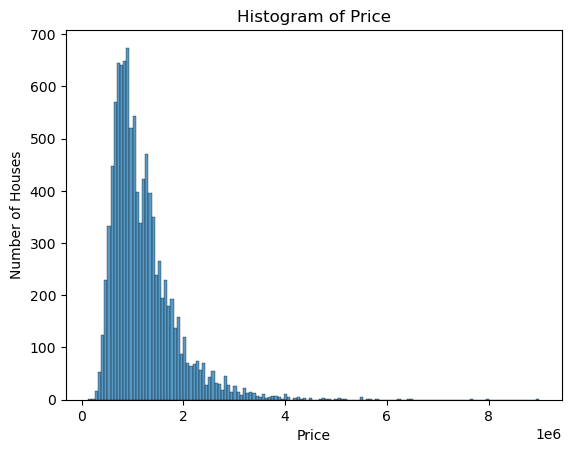

In [22]:
# Create a histogram plot of Price
sns.histplot(data=housing_dropped['Price'])
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Number of Houses')
plt.show()

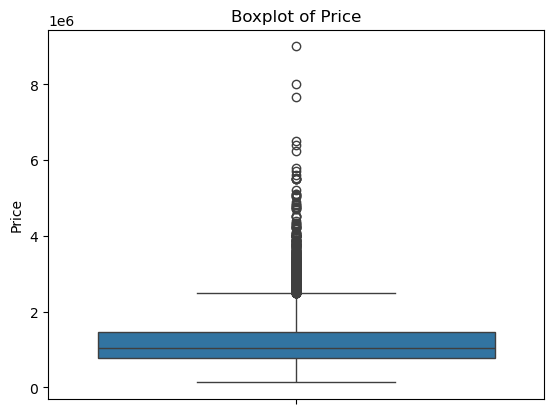

In [23]:
# Create a boxplot of Price
sns.boxplot(data=housing_dropped['Price'])
plt.title('Boxplot of Price')
plt.ylabel('Price')
plt.show()

### Boxplot Analysis

From the graph above we can see that there are a lot of outliers in the higher priced houses. We will look at two different methods to handle these outliers, zscore and Inter-Quartile Range (IQR). 

For z-scores we will look for any data points that lie outside of three standard deviations from the mean. 

Using interquartile range, we will isolate any data points that lie outside of the 25th and 75th percentiles. 


## Dataset Creation

### Z-score Dataset

In [24]:
# Calculate the zscore
zscores = zscore(housing_dropped['Price'])

# Set the threshold for 3 standard deviations
threshold = 3 

housing_dropped_zscore = housing_dropped.copy()
housing_dropped_zscore = housing_dropped_zscore.loc[np.abs(zscores) < threshold].copy()
print(f"There are {housing_dropped_zscore.shape[0]} rows and {housing_dropped_zscore.shape[1]} columns.")

# Create a log of Price
#housing_dropped_zscore['Price_log'] = np.log(housing_dropped_zscore['Price'])

There are 10380 rows and 19 columns.


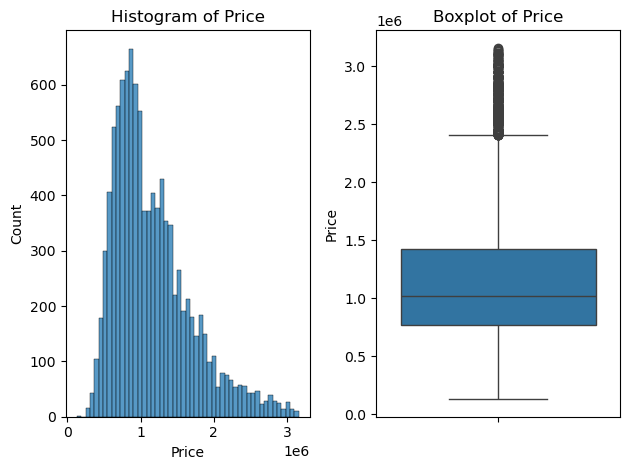

In [25]:
visualize_distribution(housing_dropped_zscore, 'Price')

### IQR Dataset

In [26]:
# Copy the housing dropped dataset
housing_dropped_iqr = housing_dropped.copy()
# Remove the outliers from Price using InterQuartile Range(IQR)
# Calculate the first quantile
Q1 = housing_dropped_iqr['Price'].quantile(0.25)
# Calculate the third quantile
Q3 = housing_dropped_iqr['Price'].quantile(0.75)

# Calculate the interquartile range
IQR = Q3 - Q1

# Define the threshold for outliers
threshold = 1.5

# Define the upper and lower bounds
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Remove outliers
housing_dropped_iqr = housing_dropped_iqr.loc[(housing_dropped_iqr['Price'] >= lower_bound) & (housing_dropped_iqr['Price'] <= upper_bound), :]
print(f"Shape of dataset after dropping outliers in Price: {housing_dropped_iqr.shape}")

Shape of dataset after dropping outliers in Price: (10062, 19)


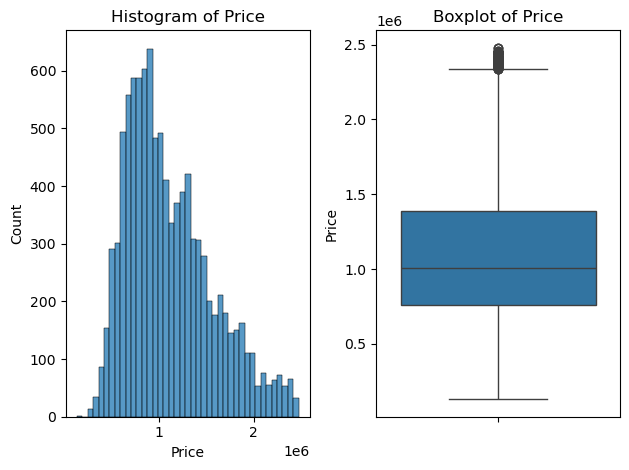

In [27]:
visualize_distribution(housing_dropped_iqr, 'Price')

In [28]:
get_skew_kurtosis(housing_dropped_zscore, 'Price')

The skew of Price is: 1.112699026633222
The kurtosis of Price is: 1.074573064350826


In [29]:
# Label encode all of the dataframes
housing_dropped = encode_labels(housing_dropped)
housing_dropped_zscore = encode_labels(housing_dropped_zscore)
housing_dropped_iqr = encode_labels(housing_dropped_iqr)

In [30]:
outlier_dfs = {'Housing Dropped': housing_dropped, 'Housing Dropped Zscore': housing_dropped_zscore, 'Housing Dropped IQR': housing_dropped_iqr}

## Visualize Models


Dataset: Housing Dropped


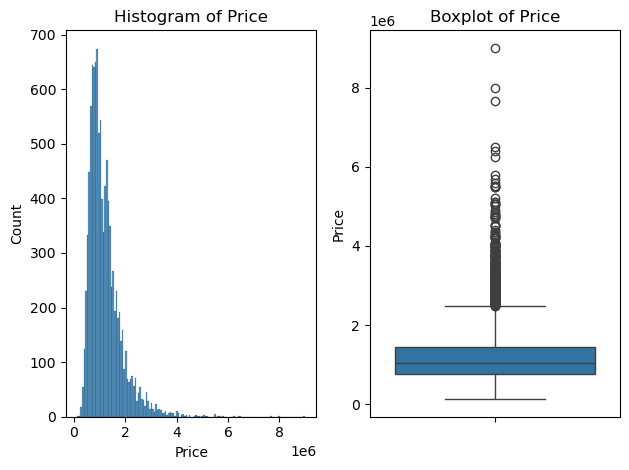

Housing Dropped Skew and Kurtosis:
The skew of Price is: 2.2534340892543265
The kurtosis of Price is: 10.006420101774543

Dataset: Housing Dropped Zscore


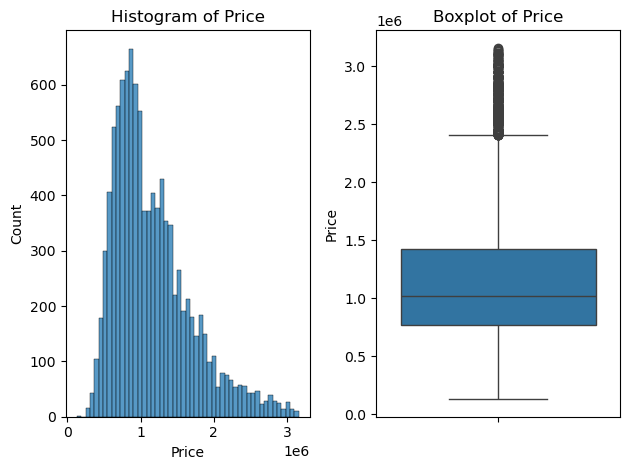

Housing Dropped Zscore Skew and Kurtosis:
The skew of Price is: 1.112699026633222
The kurtosis of Price is: 1.074573064350826

Dataset: Housing Dropped IQR


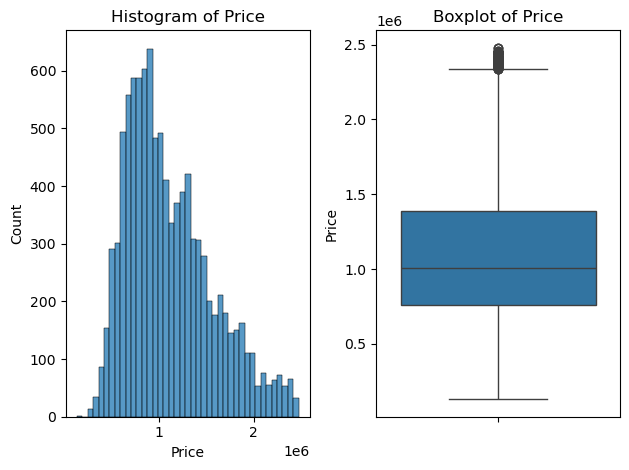

Housing Dropped IQR Skew and Kurtosis:
The skew of Price is: 0.7638560328319632
The kurtosis of Price is: 0.005404221949245169



In [31]:
for name, df in outlier_dfs.items():
    print(f"Dataset: {name}")
    visualize_distribution(df, 'Price')
    print(f"{name} Skew and Kurtosis:")
    get_skew_kurtosis(df, 'Price')
    print()

## Build Cluster Models to Subset Data

We would like to see if we can achieve more normal distributions of the Price variable by subsetting the data using Kmeans clustering.

In [32]:
encoded_data = encode_labels(housing_dropped)
output = run_models(encoded_data)

In [33]:
tuned_output = run_models_with_tuning(housing_dropped_iqr)

KeyboardInterrupt: 

In [ ]:
tuned_scores = get_metrics(tuned_output)
tuned_scores

In [ ]:
tuned_features = get_feature_importance(tuned_output)
tuned_features

In [ ]:
tuned_zscore_output = run_models_with_tuning(housing_dropped_zscore)

Name: Housing Dropped
               Model           MSE           RMSE            MAE        R2
0  Linear Regression  1.702651e+11  412631.881350  289614.385885  0.514055
1      Decision Tree  1.635562e+11  404420.821077  255145.895409  0.533202
2      Random Forest  7.635600e+10  276325.893887  178250.255528  0.782076
3                XGB  7.466918e+10  273256.611909  179099.839099  0.786890
               Model   Feature1  Feature2  Feature3      Feature4   Feature5  \
0  Linear Regression  Longitude  Latitude      Type  IsWaterfront   Bathroom   
1      Decision Tree   Distance  Postcode  Landsize      Bedroom2  Longitude   
2      Random Forest   Distance  Postcode  Landsize         Rooms  Longitude   

    Importance1   Importance2    Importance3    Importance4    Importance5  
0  1.345654e+06 -1.067264e+06 -372672.517107  346572.310960  234331.667287  
1  2.756792e-01  1.843371e-01       0.133331       0.091859       0.058298  
2  2.615680e-01  1.925860e-01       0.135601       

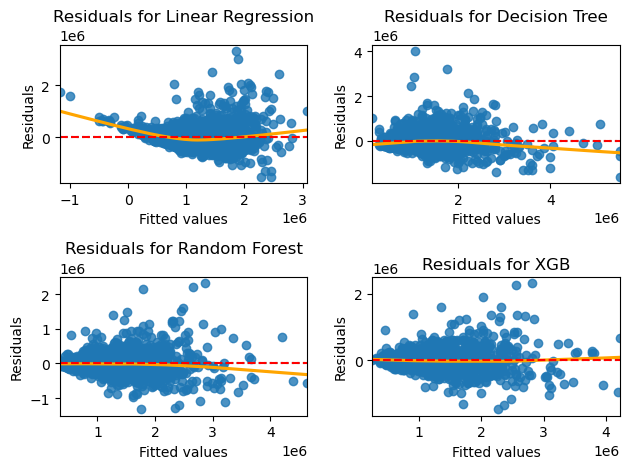

Name: Housing Dropped Zscore
               Model           MSE           RMSE            MAE        R2
0  Linear Regression  1.263254e+11  355422.781251  263626.336332  0.529707
1      Decision Tree  1.138862e+11  337470.288322  230143.290944  0.576016
2      Random Forest  5.838546e+10  241630.829056  162701.001879  0.782638
3                XGB  5.541268e+10  235398.984670  164203.224538  0.793706
               Model   Feature1  Feature2      Feature3 Feature4   Feature5  \
0  Linear Regression  Longitude  Latitude  IsWaterfront     Type   Bathroom   
1      Decision Tree   Distance  Postcode      Landsize    Rooms  Longitude   
2      Random Forest   Distance  Postcode      Landsize    Rooms  Longitude   

    Importance1   Importance2    Importance3    Importance4    Importance5  
0  1.279784e+06 -1.009288e+06  387838.602569 -314141.845260  150263.926000  
1  2.785148e-01  2.102293e-01       0.113532       0.072319       0.072154  
2  2.792674e-01  2.055802e-01       0.127401    

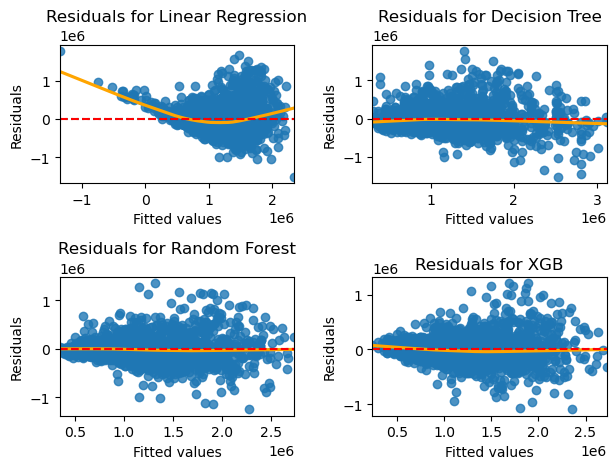

Name: Housing Dropped IQR
               Model           MSE           RMSE            MAE        R2
0  Linear Regression  9.077955e+10  301296.443979  225158.913033  0.550277
1      Decision Tree  9.159587e+10  302648.094235  211754.803775  0.546233
2      Random Forest  4.114046e+10  202831.118469  144277.653145  0.796190
3                XGB  4.285397e+10  207011.997473  149264.019654  0.787701
               Model   Feature1   Feature2      Feature3  Feature4  Feature5  \
0  Linear Regression  Longitude   Latitude  IsWaterfront      Type     Rooms   
1      Decision Tree   Latitude  Longitude      Distance  Landsize     Rooms   
2      Random Forest   Distance   Latitude     Longitude  Landsize  Postcode   

    Importance1    Importance2    Importance3    Importance4    Importance5  
0  1.118927e+06 -942269.210930  350322.409617 -265722.727841  138868.560604  
1  2.371355e-01       0.196220       0.163023       0.109779       0.100645  
2  1.957970e-01       0.175253       0.13241

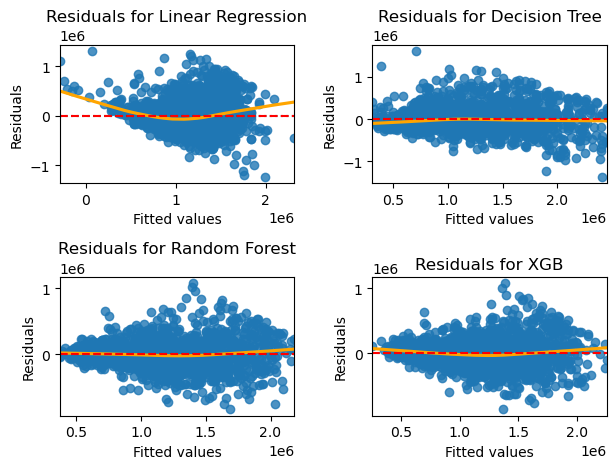

In [46]:
for name, df in outlier_dfs.items():
    print(f"Name: {name}")
    output = run_models(df)
    scores_df = get_metrics(output)
    print(scores_df)
    feature_importance = get_feature_importance(output)
    print(feature_importance)
    plot_residuals(output)

,Model,MSE,RMSE,MAE,R2
0,Linear Regression,9.077955e+10,301296.443979,225158.913033,0.550277
1,Decision Tree,9.159587e+10,302648.094235,211754.803775,0.546233
2,Random Forest,4.114046e+10,202831.118469,144277.653145,0.796190
3,XGB,4.285397e+10,207011.997473,149264.019654,0.787701


In [ ]:
scores_df = get_metrics(output)
scores_df

In [ ]:
feature_importance = get_feature_importance(output)
feature_importance

Running clustering for Housing Dropped dataset...
Features: ['Longitude' 'Latitude' 'IsWaterfront' 'Type' 'Rooms']
Clustered Data Shape: (10505, 19)


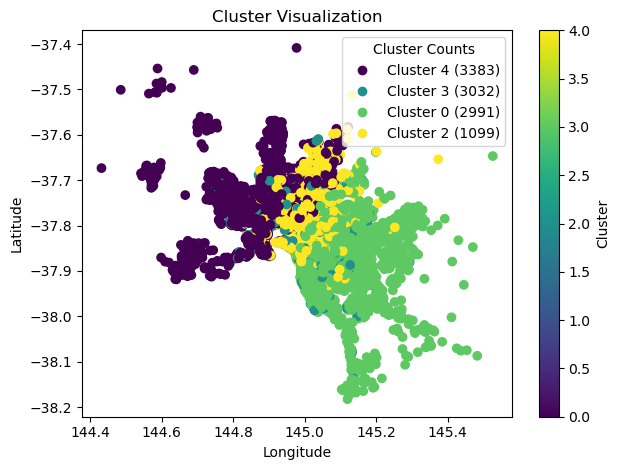

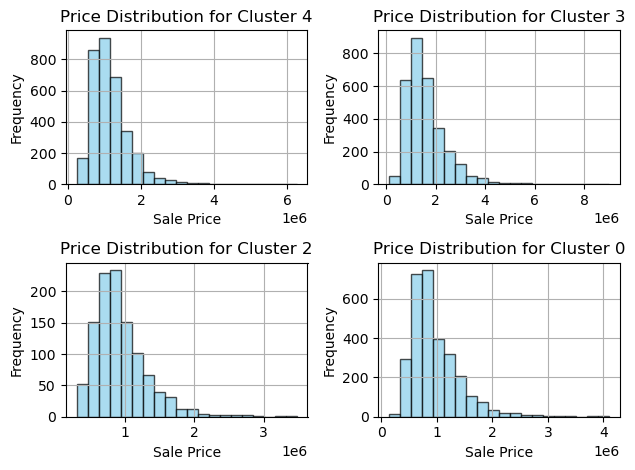

Features: ['Latitude' 'Longitude' 'Distance' 'Landsize' 'Rooms']
Clustered Data Shape: (9997, 19)


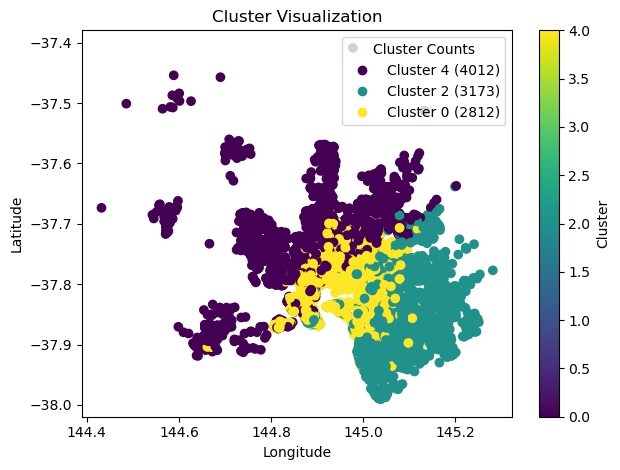

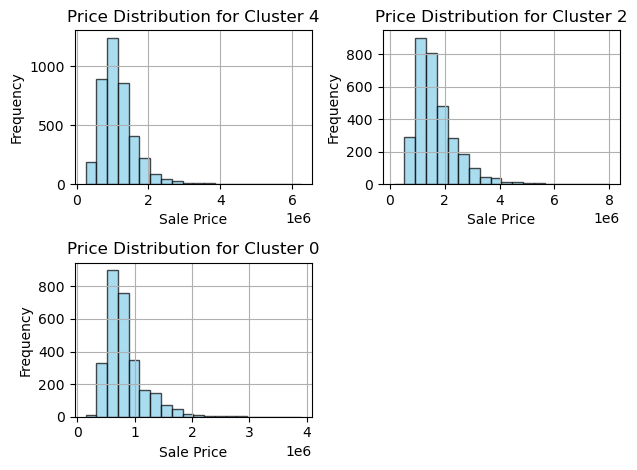

Features: ['Distance' 'Latitude' 'Longitude' 'Landsize' 'Postcode']
Clustered Data Shape: (10360, 19)


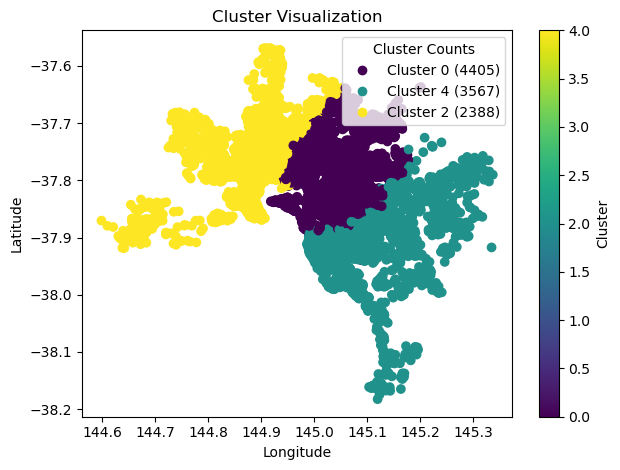

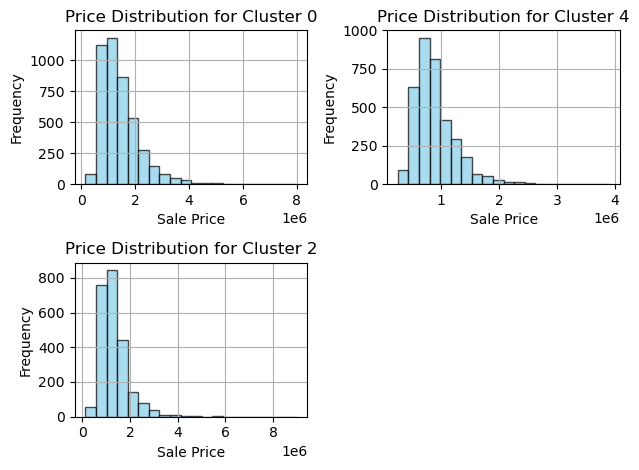

Running clustering for Housing Dropped Zscore dataset...
Features: ['Longitude' 'Latitude' 'IsWaterfront' 'Type' 'Rooms']
Clustered Data Shape: (10324, 19)


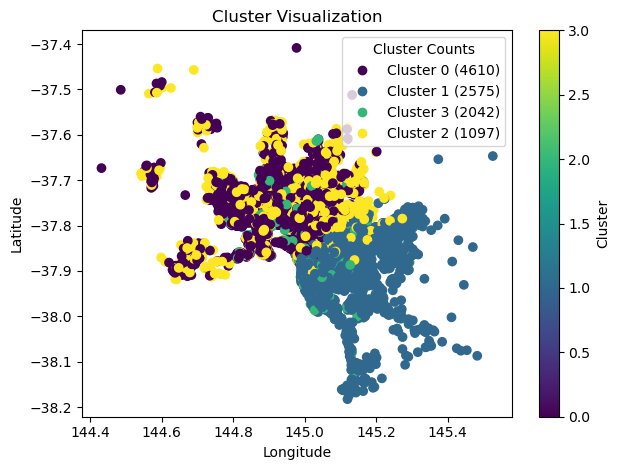

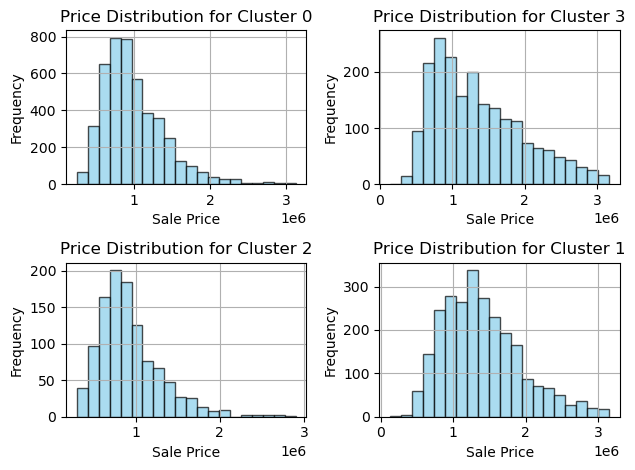

Features: ['Latitude' 'Longitude' 'Distance' 'Landsize' 'Rooms']
Clustered Data Shape: (10379, 19)


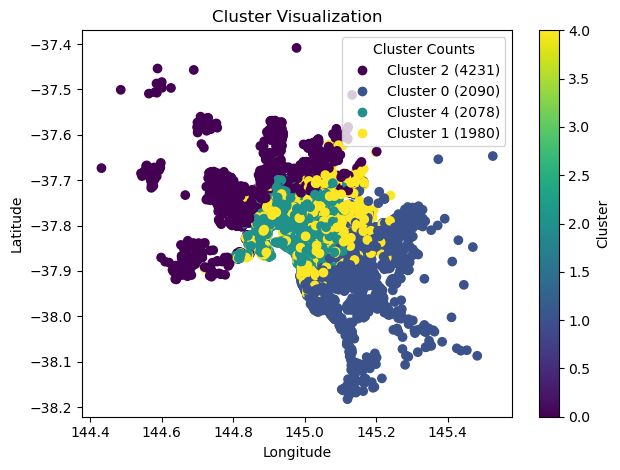

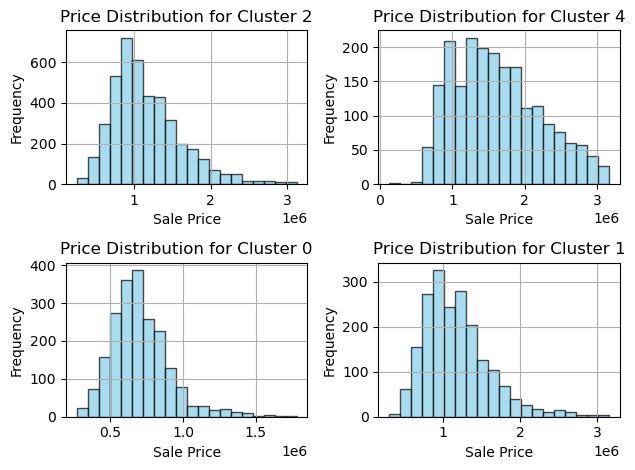

Features: ['Distance' 'Latitude' 'Longitude' 'Landsize' 'Postcode']
Clustered Data Shape: (10177, 19)


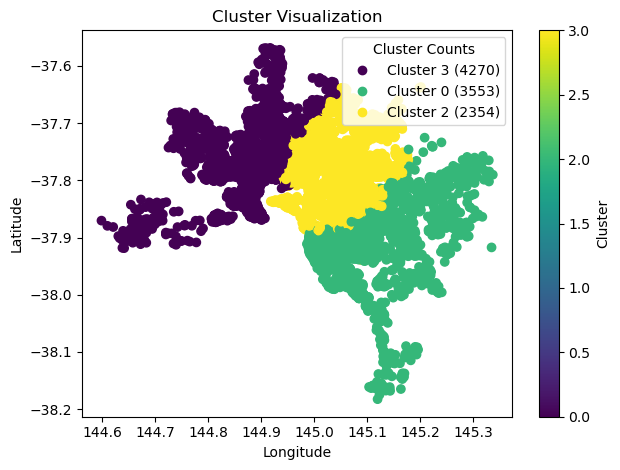

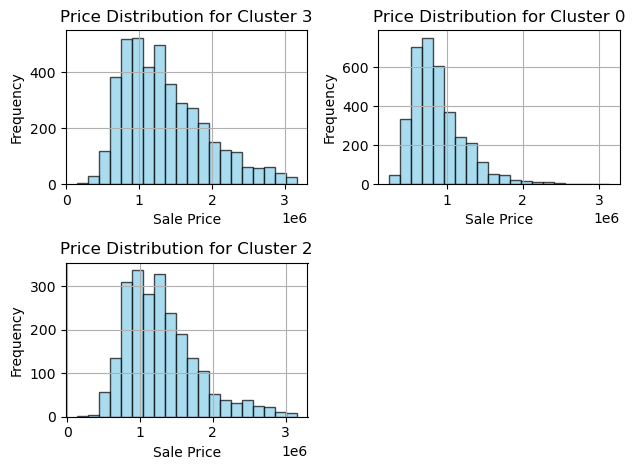

Running clustering for Housing Dropped IQR dataset...
Features: ['Longitude' 'Latitude' 'IsWaterfront' 'Type' 'Rooms']
Clustered Data Shape: (10013, 19)


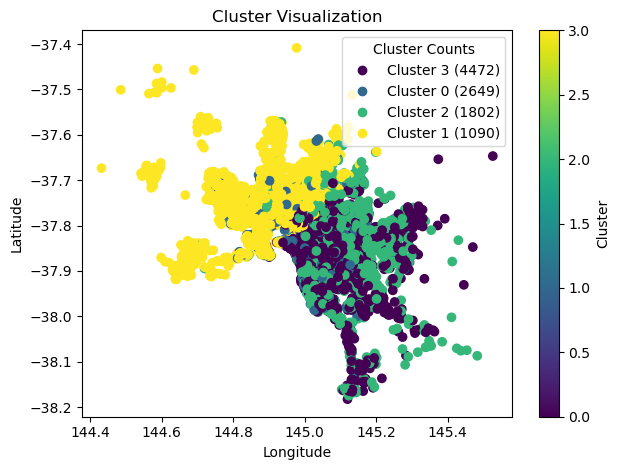

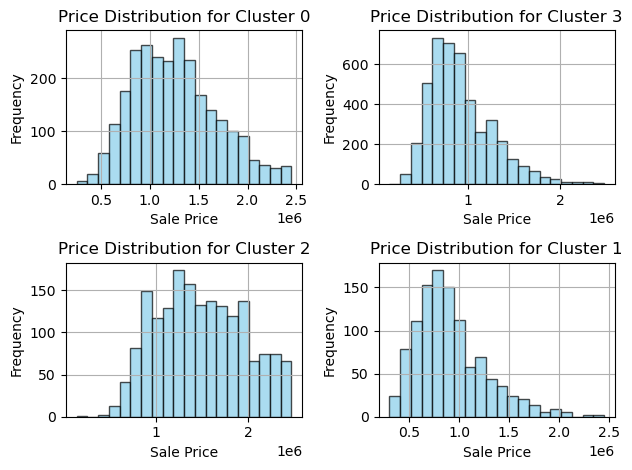

Features: ['Latitude' 'Longitude' 'Distance' 'Landsize' 'Rooms']
Clustered Data Shape: (9556, 19)


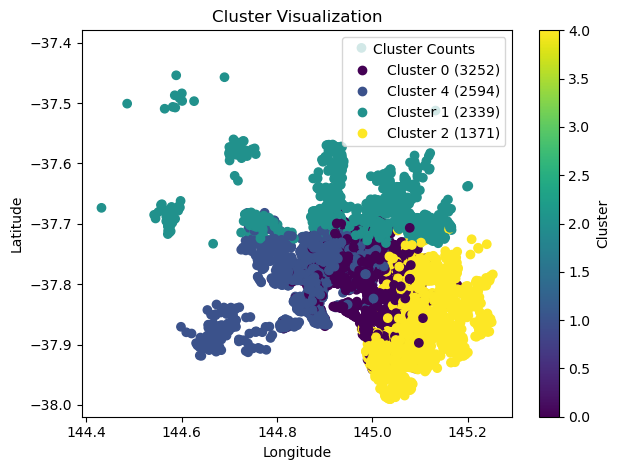

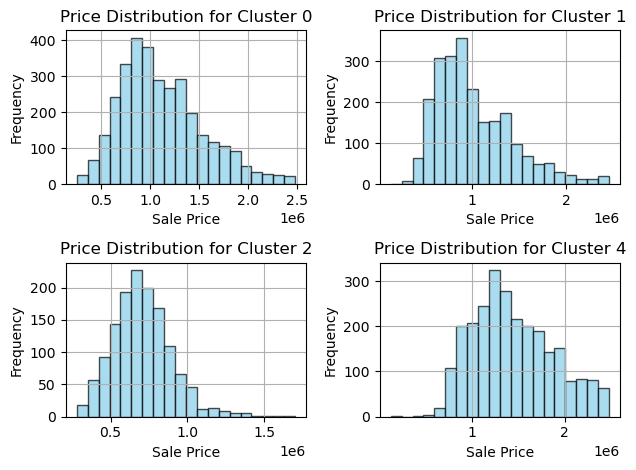

Features: ['Distance' 'Latitude' 'Longitude' 'Landsize' 'Postcode']
Clustered Data Shape: (9858, 19)


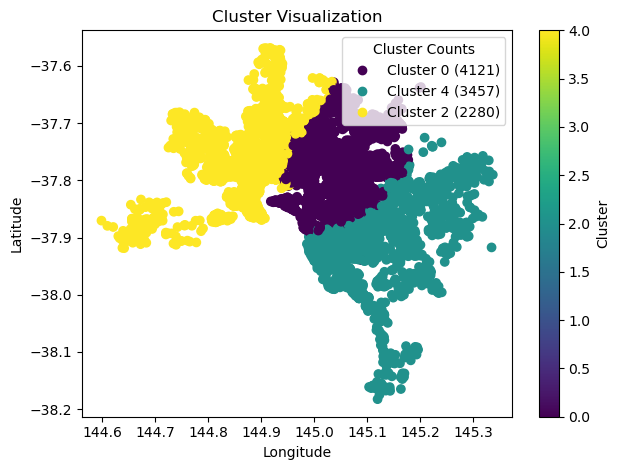

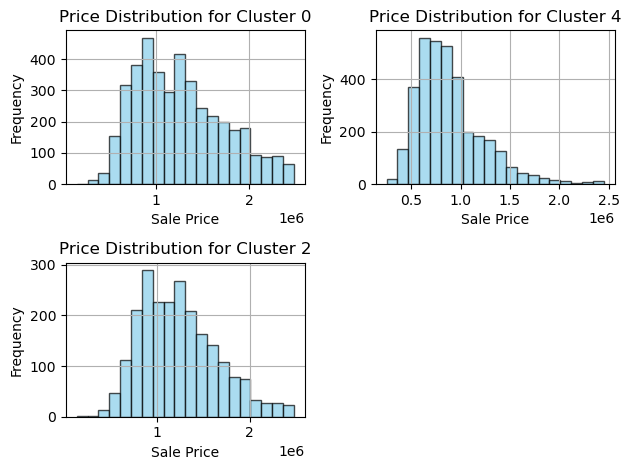

In [48]:
# Iterate over each dataset
for dataset_name, df in outlier_dfs.items():
    print(f"Running clustering for {dataset_name} dataset...")
    
    # Iterate over each model
    for model_name in feature_importance['Model'].unique():
        # Extract features based on the model importance
        features = feature_importance.loc[feature_importance['Model'] == model_name, 
                                           ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5']].values.flatten()
        
        # Include 'Price'
        #features = np.append(features, 'Price')
        
        # Run preliminary clustering models
        print(f"Features: {features}")
        clustered_data = run_cluster_model(df, features)
        
        # Visualize clusters and price distributions
        visualize_clusters(clustered_data)
        visualize_cluster_distributions(clustered_data, 'Price')

Clustered Data Shape: (9349, 19)


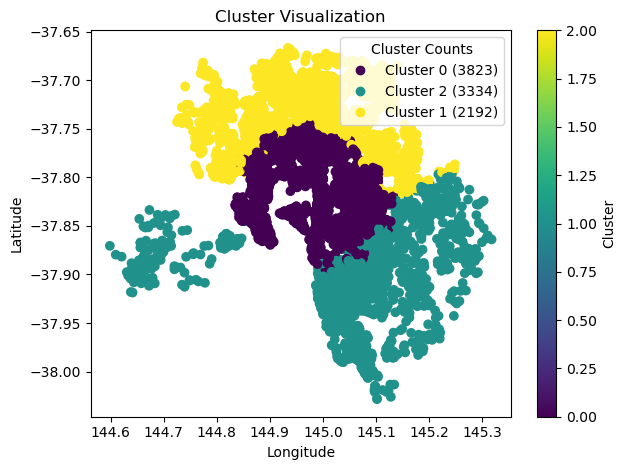

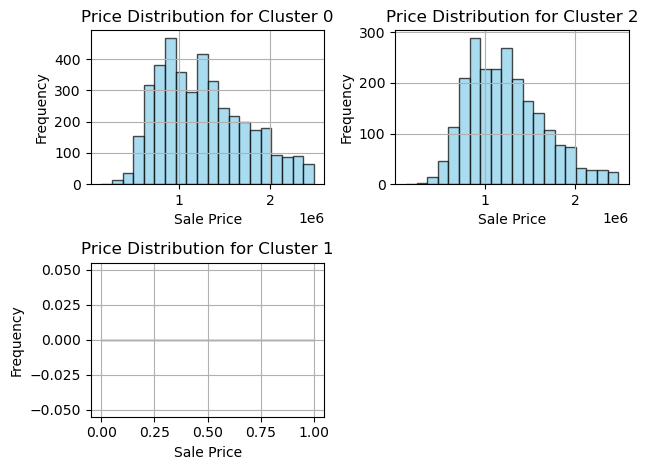

In [53]:
features = ['Distance', 'Latitude']
# Run preliminary clustering models
distance_clustered_data = run_cluster_model(housing_dropped_iqr, features)
# Visualize clusters and price distributions
visualize_clusters(distance_clustered_data)
visualize_cluster_distributions(distance_clustered_data, 'Price')

               Model           MSE           RMSE            MAE        R2
0  Linear Regression  8.116487e+10  284894.483877  212947.127560  0.583038
1      Decision Tree  8.675269e+10  294538.103864  209192.425456  0.554332
2      Random Forest  4.292004e+10  207171.528340  148476.484016  0.779510
3                XGB  4.140525e+10  203482.799733  146985.232695  0.787292
               Model   Feature1  Feature2      Feature3 Feature4   Feature5  \
0  Linear Regression  Longitude  Latitude  IsWaterfront     Type      Rooms   
1      Decision Tree   Distance  Postcode      Landsize    Rooms  Longitude   
2      Random Forest   Distance  Postcode      Landsize    Rooms  Longitude   

    Importance1    Importance2    Importance3    Importance4    Importance5  
0  1.120599e+06 -993608.585280  282420.085621 -244827.438000  134673.720557  
1  2.588049e-01       0.232936       0.161129       0.075792       0.063821  
2  2.584701e-01       0.230630       0.154492       0.080012       0.06319

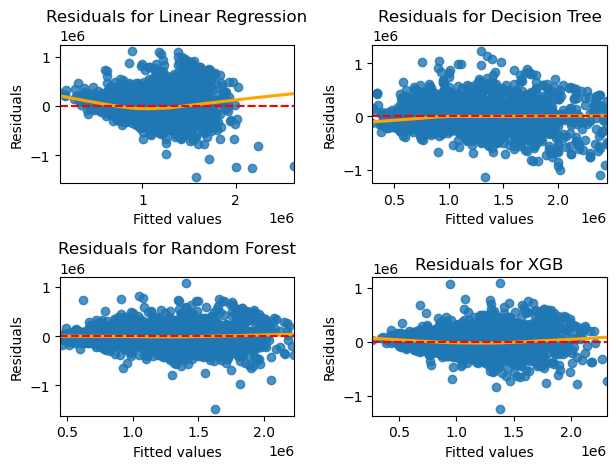

In [58]:
# Run models on clustered_data
output = run_models(clustered_data)
clustered_scores = get_metrics(output)
print(clustered_scores)
clustered_features = get_feature_importance(output)
print(clustered_features)
plot_residuals(output)

In [60]:
features = ['Latitude', 'Distance', 'Longitude', 'Postcode', 'Landsize']
test_clustered_df = run_cluster_model(housing_dropped_iqr, features)
# Run models on individual clusters in distance_clustered_data
for cluster in test_clustered_df['Cluster'].unique():
    print(f"Cluster: {cluster}")
    cluster_data = test_clustered_df[test_clustered_df['Cluster'] == cluster].copy()
    cluster_data.drop('Cluster', axis=1, inplace=True)
    output = run_models(cluster_data)
    scores_df = get_metrics(output)
    print(scores_df)
    feature_importance = get_feature_importance(output)
    print(feature_importance)

Clustered Data Shape: (9858, 19)
Cluster: 0
               Model           MSE           RMSE            MAE        R2
0  Linear Regression  8.623971e+10  293665.978872  227389.146382  0.636766
1      Decision Tree  1.265627e+11  355756.513469  254763.980606  0.466929
2      Random Forest  5.536425e+10  235296.089101  176667.434073  0.766811
               Model  Feature1   Feature2  Feature3    Feature4      Feature5  \
0  Linear Regression  Latitude  Longitude      Type       Rooms  IsWaterfront   
1      Decision Tree  Latitude      Rooms  Landsize  Regionname     Longitude   
2      Random Forest  Latitude      Rooms  Landsize  Regionname     Longitude   

    Importance1   Importance2    Importance3    Importance4    Importance5  
0 -4.768063e+06  1.524590e+06 -298015.756713  186956.171314  185524.763759  
1  4.134663e-01  1.277048e-01       0.110682       0.054771       0.041290  
2  4.115021e-01  1.344965e-01       0.112840       0.056169       0.040973  
Cluster: 4
            

In [ ]:
# Run models on individual clusters in distance_clustered_data
for cluster in distance_clustered_data['Cluster'].unique():
    print(f"Cluster: {cluster}")
    cluster_data = distance_clustered_data[distance_clustered_data['Cluster'] == cluster].copy()
    cluster_data.drop('Cluster', axis=1, inplace=True)
    output = run_models(cluster_data)
    scores_df = get_metrics(output)
    print(scores_df)
    feature_importance = get_feature_importance(output)
    print(feature_importance)

## Price Analysis

We can see that the distribution of Price is positively skewed, with significant outliers in the right tail of the distribution. 

We will apply a logarithmic transform to help normalize the distribution.

## XGBoost Model

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
